# **News Generator Term Project**

**Swee Loke** | SCS3546 (Deep Learning) | University of Toronto | Dec 1, 2020

This project use different experiments to decide how to construct the datasets and parameters to use to train a news generation model. Although it is called "News Generator", the model can be trained with any text data and will generate text style similar to the trained datasets.

Data Source: 

* Kaggle ("clmentbisaillon/fake-and-real-news-dataset")
* Kaggle ("rmisra/news-category-dataset")

# **PART 2: Training the model**

*(Note: PART 1 is in a different notebook)*

This notebook first runs different experiments and select the datasets, embedding and model parameters, and then use the selected parameters for the final model. 

The experiments are:
1. Comparing **2 datasets**

2. Comparing **max_sequence_length** (10, 20, 30)

3. Comparing **using or not using** pretrain embeddings

4. Comparing **different** pretrained embeddings 

5. Comparing **different** number of LSTM layer

6. Comparing **different** RNN units per LSTM layer


There are several classes implemented to support running different experiements easily. It allows us to generate the required vocab and train/validation datasets in one call (with a text file name, vocab_size, embedding dimension, max_seq_len, validation_split and batch_size). 

* VocabClass 

    This class is initialized with a specific file and max_tokens (vocabulary size). We also allow a limit_text_size if we want to truncate the input to a fixed size. This is useful when we want to compare different datasets where the text file sizes are very different.

* PretrainedEmbedding

  This class loads the GloVe pretrained embedding of a specified dimension and initializes an embedding matrix given a set of vocabulary (passed in as an instance of Vocab_Class)

* TextDataset

  This class generate the VocabClass, PretrainedEmbedding and the train/validation datasets with a specified batch size and train_validation split.

* Experiment 

  This class builds a model, train it with a specified number of epoch with the provided datasets, it also returns the result in a dictionary that contains the performance stats, the trained model and the model with batch size=1 for text generation. It also support us continue training from the previous trained model so that we can resume the training with additional epoch.

* ResultsDisplay

  This class is for displaying the results of different experiments, include showing plots of the performance stats and running the text generation models with the predefined set of starting strings. There is also method for generating individual text.


**This is all experimental code, not production qualtiy - no error checking is done.  It is merely for the purpose of running different experiments.**







In [2]:
# First we must mount google drive 
import os.path
from google.colab import files
from google.colab import drive
GDRIVE_BASE_PATH = '/content/gdrive'
drive.mount(GDRIVE_BASE_PATH, force_remount=True)

# # Load the project from GitHub and adjust our `HOME_DIR`
HOME_DIR = f'{GDRIVE_BASE_PATH}/My Drive/Colab Notebooks/NewsGenerator/'
DATA_DIR = f'{GDRIVE_BASE_PATH}/My Drive/Colab Notebooks/data/'
# # Going to the home directory and loading the project setup
% cd '$HOME_DIR'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/NewsGenerator


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.layers.experimental.preprocessing import TextVectorization
from keras.layers import LSTM
import matplotlib.pyplot as plt
import datetime

In [4]:
# This class keeps keeps our vocabulary and also text_as_int and text_in_tokens
class VocabClass():
  def __init__(self, text_file_path, max_tokens, limit_text_size=0): # 0 = no limit, for reference, the small_news text has 5852253 and long news has 8373511
    self.text_file_path = text_file_path
    self.max_tokens = max_tokens
    self.limit_text_size = limit_text_size # This is to limit the input text size if we don't want to process too much

    self.__get_vocab_from_input_file(text_file_path, max_tokens)

  def __get_list_of_strings_from_file(self, file_name):
    with open(file_name) as f:
      lines = list(tuple(open(file_name, 'r')))
      # Remove any new line so that all lines are merged.
      lines = [ x.replace('\n', '') for x in lines]

    return lines

  def __create_vocab(self, raw_data, maximum_token):
    vectorizer = TextVectorization(max_tokens=maximum_token)
    text_ds = tf.data.Dataset.from_tensor_slices([raw_data])
    vectorizer.adapt(text_ds)
    self.vectorizer = vectorizer
    self.vocab = vectorizer.get_vocabulary()
    self.vocab_size = len(self.vocab)
    self.word2idx =  {u:i for i, u in enumerate(self.vocab)}
    self.idx2word = np.array(self.vocab)
    temp = vectorizer([raw_data]).numpy()
    self.text_as_int = [y for x in temp for y in x]
    self.text_in_tokens = [self.idx2word[i] for i in self.text_as_int]

  # We clean up the text as well, keep only the characters listed
  def __get_vocab_from_input_file(self, file_name, max_tokens):
    samples = self.__get_list_of_strings_from_file(file_name)
    # join each line with a EOS token (which will likely map to unknown word)
    joined_samples = ' '.join(samples)
    # We only want to include common characters
    PERMITTED_CHARS = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_- .,:;!?'" 
    joined_samples = "".join(c for c in joined_samples if c in PERMITTED_CHARS)

    # if we set a limit, truncate it here 
    # this is useful when we want to compare text of different lenth
    if (self.limit_text_size > 0):
        joined_samples = joined_samples[:self.limit_text_size]
    self.__create_vocab(joined_samples, max_tokens)


In [5]:
# This loads pretrained gloVe.6B embedding and create an embedding matrix for our vocab
class PretrainedEmbedding():
  def __init__(self, embedding_dim, vocab_class):
        self.embedding_dim = embedding_dim
        self.my_vocab = vocab_class
        if embedding_dim > 0:
          self.embedding_matrix = self.__create_embedding_matrix(embedding_dim, vocab_class)
        else:
          self.embedding_matrix = None

  # This function expects the embedding_dim of 50, 100, 200 or 300
  # No error checking of the dimension
  def __create_embedding_matrix(self, embedding_dim, vocab):
    # Load the embedding files 
    path_to_glove_file =  DATA_DIR+"glove.6B."+str(embedding_dim)+"d.txt"
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = vocab.vocab_size + 2
    self.hits = 0
    self.misses = 0
    self.missed_words = [] # for debugged
    self.hit_words = []  # for debugged

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in vocab.word2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            self.hits += 1
            self.hit_words.append(word)
        else:
            self.misses += 1
            #print(word)
            self.missed_words.append(word)
    print("Converted %d words (%d misses) in the embedding" % (self.hits, self.misses))
    return embedding_matrix

In [6]:
# This class creates everything (vocab, embedding, datasets)
# It is mean for us to easily generate datasets using a filename 
# It takes the content of a file, let's say starts with 
#       "Today is a very good day, I am going for a walk. Then I am going to buy some clothes..... "
# It will chop the text up into chunks of "max_seq_len", and create one test sample with each chunk. 
# Assume we have the max_seq_len of 7, it is going to create samples of
# "today is a very good day i",
# "am going for a walk then i",
# "am going to buy some clothes...",
# and the rest. 
# The last chunk that does not have at least max_seq_len will be dropped. 
# 
# For each sample, it will create the training input (X) and targt (Y) sequences, by dropping the last word 
# for X and dropping the first word for Y. 
# So for "today is a very good day i", the generated X and Y pairs are:
# X: "today is a very good day"
# Y: "is a very good day i"
# Then it will create tf train/validation datasets based on the specified split and also construct the batch 
# datasets using the specified batch_size 
class TextDataset:
  def __init__(self, 
           text_file_path, # specify where the text file is
           limit_text_size,# This limit the amount of text (in char) we use from input text file (after parsed)
           max_tokens,     # max words in to be kept in vocab
           embedding_dim,  # embedding dimension (matching the glove pretrained embedding dimension) 
           max_seq_len,    # max size of each sequence 
           validation_split, # size of validation samples wrt the total
           batch_size        # batch size for training
           ):
    
    self.text_file_path = text_file_path
    self.max_tokens = max_tokens
    self.embedding_dim = embedding_dim
    self.max_seq_len = max_seq_len
    self.validation_split = validation_split
    self.batch_size = batch_size
    self.limit_text_size = limit_text_size

    # Generate all vocab (including embedding) and train/test datasets
    self.generate_vocab_embedding_dataset()

  # creating tn input and target text by shifting one word to the left 
  # for X, drop the last word
  # for Y, drop the first word 
  def __split_input_target(self, chunk):
      input_text = chunk[:-1]
      target_text = chunk[1:]
      return input_text, target_text

  #create train test split assemble into different datasets of batch size 
  def __create_train_val_datasets(self, vocab_class, max_seq_len, validation_split, batch_size):

      raw_data_tokens = vocab_class.text_as_int
      seq_length = max_seq_len
      total_tokens = len(raw_data_tokens)
      #print("total_tokens:", total_tokens)
      examples_per_epoch = total_tokens//(seq_length+1)
      #print("examples_per_epoch", examples_per_epoch)

      # Create training examples / targets
      word_dataset = tf.data.Dataset.from_tensor_slices(raw_data_tokens)
      sequences = word_dataset.batch(seq_length+1, drop_remainder=True)

      # for each sequence, we construct the input and target sets (i.e., X, Y)
      dataset = sequences.map(self.__split_input_target)

      print("\ndataset size:", dataset.cardinality().numpy())

      BUFFER_SIZE = 10000
      RANDOM_SEED = 123 
      # shuffle the dataset before we split into train test
      dataset = dataset.shuffle(BUFFER_SIZE, seed=RANDOM_SEED)

      # split the dataset into train and test
      total_size =  dataset.cardinality().numpy()
      num_validation_samples = int(validation_split * total_size)
      num_train_samples = total_size - num_validation_samples
      print("num_validation_samples:", num_validation_samples)
      
      dataset_train = dataset.take(num_train_samples) 
      dataset_val = dataset.skip(num_train_samples)

      print("dataset_train size:", dataset_train.cardinality().numpy())
      print("dataset_val size:", dataset_val.cardinality().numpy())

      # for debug
      for input_example, target_example in dataset_val.take(1):
        print(input_example)
        print(target_example)
        print('Input data: ', repr(' '.join(vocab_class.idx2word[input_example.numpy()])))
        print('Target data:', repr(' '.join(vocab_class.idx2word[target_example.numpy()])))

      dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)
      dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)
      print("dataset_train batch size:", dataset_train.cardinality().numpy())
      print("dataset_val batch size:", dataset_val.cardinality().numpy())

      return dataset_train, dataset_val

  # This simplify the process of creating vocab+embedding+dataset for testing models
  def generate_vocab_embedding_dataset(self):

    # First create the vocab
    self.my_vocab = VocabClass(self.text_file_path, self.max_tokens, self.limit_text_size)

    # Create the embedding_matrix based on glove pretrain embedding of the specified dimension
    self.embedding = PretrainedEmbedding(self.embedding_dim, self.my_vocab)        

    # Now create the dataset 
    self.dataset_train, self.dataset_val = self.__create_train_val_datasets(self.my_vocab, self.max_seq_len, self.validation_split, self.batch_size )


The following are classes and utilities for model training and experiments.


In [7]:
# This has to be outside of classes, as it is called by others which will have no self object passed in 
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# This class will build the model, train and set up the predict model for us to generate text later. 
class Experiment():
  def __init__(self,     
                   experiment_name,
                   training_param_dict,
                   embedding_dim, 
                   embedding_matrix, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   embedding_trainable, # if we pass in embedding_matrix, do we want it to be trainable? N/A if embedding_matrix is None
                   dataset_class): 

    self.name = experiment_name
    self.vocab_size = dataset_class.my_vocab.vocab_size
    # passing in the training parameters in a dictionary so that we don't have to modify method signature when we decide to
    # change model type or add/delete parameters
    self.training_param_dict = training_param_dict
    self.embedding_dim = embedding_dim
    self.embedding_matrix = embedding_matrix
    self.embedding_trainable = embedding_trainable
    self.dataset_class = dataset_class

    print("dataset_train batch size:", dataset_class.dataset_train.cardinality().numpy())
    print("dataset_val batch size:", dataset_class.dataset_val.cardinality().numpy())

  # private class for building models 
  def __build_model(self, vocab_size, embedding_dim, num_lstm_layer, rnn_units, batch_size, dropout, embedding_matrix=None, embedding_trainable=False):

    # print("rnn_units:",rnn_units)
    # print("embedding_dim:",embedding_dim)
    # print("num_lstm_layer:",num_lstm_layer)
    # print("batch_size:",batch_size)
    # print("dropout:",dropout)
    # print("embedding_trainable:",embedding_trainable)

    model = tf.keras.Sequential()
    if (embedding_matrix is None):
      # not passing in any embedding 
      # print("adding default_embedding...")
      model.add(tf.keras.layers.Embedding(vocab_size+2, 
                                          embedding_dim,
                                          batch_input_shape=[batch_size, None], 
                                          name="empty-embedding"))
    else:
      print(embedding_matrix.shape)
      model.add(tf.keras.layers.Embedding(
                            vocab_size+2, 
                            embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            batch_input_shape=[batch_size, None],
                            trainable=embedding_trainable, name="pretrained-embedding"))

    for i in range(num_lstm_layer):
        # we add drop out before the LSTM 
        # if (dropout):
        #     model.add(tf.keras.layers.Dropout(dropout))
        model.add(tf.keras.layers.LSTM(rnn_units, return_sequences=True))
        if (dropout):
          model.add(tf.keras.layers.Dropout(dropout))

    # Last layer is Dense layer 
    model.add(tf.keras.layers.Dense(vocab_size))
    return model

  # This allows us to start the initial runs of a model or continue training the previous model for additional epoch
  def run_experiment(self,
                    memo_string, # for display only
                    prev_result,  # if we want to continue training from previous run, pass in the previous result
                    epoch ): 

    experiment_result = {}
    experiment_result['training_param'] = self.training_param_dict
    experiment_result['max_seq_len'] = self.dataset_class.max_seq_len 
    experiment_result['memo'] = self.name +":" + memo_string

    print(f"Running {experiment_result['memo']}...\n")
    # Directory where the checkpoints will be saved (want to use a diff directory each time we run)
    today_str = datetime.datetime.strftime(datetime.datetime.today(), '%m-%d-%H:%M')
    checkpoint_dir = './training_checkpoints_'+today_str
    print("checkpoint_dir:", checkpoint_dir)
    # Store the checkpoint dir name for later 
    experiment_result['checkpoint_dir'] = checkpoint_dir
    # Name of the checkpoint files
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        save_weights_only=True)

    # We allow the experiment to be continued from a previously trained model by passing in the 
    # model and we will run additional epoch as specified
    if (prev_result is None):
        my_model = self.__build_model(
            vocab_size=self.vocab_size,
            embedding_dim=self.embedding_dim,
            num_lstm_layer=self.training_param_dict['lstm_layer'],
            rnn_units=self.training_param_dict['rnn_units'],
            batch_size=self.dataset_class.batch_size,
            dropout=self.training_param_dict['dropout'],
            embedding_matrix=self.embedding_matrix,
            embedding_trainable=self.embedding_trainable
            )
        
        my_model.compile(loss=loss, optimizer='adam', metrics=['accuracy']) 
        my_model.summary()
    else:
        print("Passing in prev_model... continue training")
        print(prev_result['model'])
        my_model = prev_result['model'] 
        # my_model.summary()
        # continue training 

    # For testing logic - switch to this when we want to test with small datasets
    # Train with small batch when we want to test the logic of the code 
    # temp_result = my_model.fit(self.dataset_class.dataset_train.take(10), 
    #                                             epochs=epoch, 
    #                                             batch_size=self.dataset_class.batch_size, 
    #                                             validation_data=self.dataset_class.dataset_val.take(10), 
    #                                             callbacks=[checkpoint_callback])
    temp_result = my_model.fit(self.dataset_class.dataset_train, 
                                                epochs=epoch, 
                                                batch_size=self.dataset_class.batch_size, 
                                                validation_data=self.dataset_class.dataset_val, 
                                                callbacks=[checkpoint_callback])
    
    if (prev_result is not None):
      # we will concat the results so that all epochs can be shown in one graph
      history = {}
      h1 = prev_result['history'].history
      h2 = temp_result.history
      for key in h1.keys():
        #print(key)
        history[key] = h1[key] + h2[key]
      temp_result.history = history
      print(temp_result)
    
    experiment_result['history'] = temp_result
    experiment_result['model'] = my_model
    self.model = my_model
    print(f"Done {epoch} epoch.")

    # change the batch size for prediction
    model_predict = self.__build_model(
      self.vocab_size,
      embedding_dim=self.embedding_dim,
      num_lstm_layer=self.training_param_dict['lstm_layer'],
      rnn_units=self.training_param_dict['rnn_units'],
      batch_size=1,
      dropout=self.training_param_dict['dropout']
      )
      
    model_predict.load_weights(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()
    model_predict.build(tf.TensorShape([1, None]))
    experiment_result['predict'] = model_predict
    self.model_predict = model_predict

    return experiment_result

In [89]:
# This class is for displaying training results.
# We will use this to compare different models
class ResultsDisplay():

  def __init__(self, test_start_string_list):
    self.start_string = test_start_string_list

  # This function plots loss and accuracy plots side by side input the results from model training
  @classmethod
  def plot_loss_and_accuracy_graphs(cls, history):

    print("\n")
    plt.figure(figsize=(7, 5))

    history_d = history.history
    if 'val_accuracy' in history_d.keys():
      val_acc = history_d['val_accuracy']
      val_loss = history_d['val_loss']
      val_acc_values = history_d['val_accuracy']
      plot_validation = True
    else:
      plot_validation = False

    acc = history_d['accuracy']
    loss = history_d['loss']
    acc_values = history_d['accuracy']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    # b is for "solid blue line"
    if (plot_validation):
      plt.plot(epochs, val_loss, 'r', label='Validation loss')
      plt.title('Training and validation loss')
    else:
      plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')

    plt.subplot(1, 2, 2)

    plt.plot(epochs, acc, 'b', label='Training acc')
    if (plot_validation):
      plt.plot(epochs, val_acc, 'r', label='Validation acc')
      plt.title('Training and validation accuracy')
    else:
      plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

  # This generate texts using the model and start_string and vocabulary
  def generate_text(self, model, start_string, vocab_class, word_to_generate):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 0

    # Converting our start string to numbers (vectorizing)
    vectorizer = vocab_class.vectorizer
    input_eval = vectorizer([start_string])
    # print(input_eval.shape)
    # print(input_eval)
    #input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []#

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size = 1
    model.reset_states()
    while (num_generate < word_to_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        if (predicted_id <2 ):
          # try again
          continue
        
        num_generate += 1
        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(vocab_class.idx2word[predicted_id])

    return (' '.join(text_generated)) 

  # Use the model to generate some text using the list of start_string
  def test_generate_text(self , text_list, model, vocab_class, word_to_generate): 
    for i, text in enumerate(text_list, start=1):
      print(f"#{i}:  {text}...")
      print("        ", self.generate_text(model, start_string=text, vocab_class=vocab_class,  word_to_generate=word_to_generate))
      #print("\n")

  # This shows the graph and runs the text generation test 
  def show_experiment_results(self, result_dict, vocab):   
    print("Experiment:", result_dict['memo'])
    print("training_param:", result_dict['training_param'])
    print("max_seq_len:", result_dict['max_seq_len'])
    self.plot_loss_and_accuracy_graphs(result_dict['history'])
    self.test_generate_text(self.start_string, result_dict['predict'], vocab, 20)


# **Experiment 1:** Comparing Datasets

We will compare the accuary of running the same model with 2 different datasets, and see which one is better after the same number of epoch.

This is to decide which dataset we will to use for other experiments and our final model.  

We intentionally make the long news dataset size the same as the short news, so the quantity of the text data is not a factor. 
 
We explain the different datasets in the previous notebook (preprosessing).

First we load the short news file into sequence of 10 words. We will use max_seq_length of 10 to compare the datasets.

In [33]:
VALIDATION_SPLIT = 0.2 
BATCH_SIZE = 128 
EMBEDDING_DIM = 50 
MAX_TOKENS = 20000 # this is fixed to 20K for all tests 
TEXT_LIMIT = 5800000 # Using this as limit as it is just about the size of the short news text (so we will have both datasets about the same text length)

short_news_file_path = DATA_DIR+'short_news_text.txt'
short_news_dataset_10seq = TextDataset(short_news_file_path, TEXT_LIMIT, MAX_TOKENS, EMBEDDING_DIM, 10, VALIDATION_SPLIT, BATCH_SIZE)

Found 190189 word vectors.
Converted 18416 words (1584 misses) in the embedding

dataset size: 85282
num_validation_samples: 17056
dataset_train size: 68226
dataset_val size: 17056
dataset_train batch size: 533
dataset_val batch size: 133


In [ ]:
# Show example of news
WORD_TO_SHOW = 200
# Short news are just a title and a brief description of the news, no full body
repr(' '.join(short_news_dataset_10seq.my_vocab.text_in_tokens[:WORD_TO_SHOW]))

"'there were 2 mass shootings in texas last week but only 1 on tv she left her husband he killed their children just another day in america will smith joins [UNK] and nicky jam for the 2018 world cups official song of course it has a song hugh grant marries for the first time at age 57 the actor and his longtime girlfriend anna [UNK] tied the knot in a civil ceremony jim carrey blasts [UNK] adam schiff and democrats in new artwork the actor gives dems an [UNK] for not fighting hard enough against donald trump [UNK] [UNK] uses donald trump poop bags to pick up after her dog the [UNK] actress said using the bags is a really [UNK] therapeutic moment morgan freeman devastated that sexual harassment claims could undermine legacy it is not right to [UNK] horrific incidents of sexual assault with [UNK] compliments or humor he said in a statement donald trump is lovin new mcdonalds jingle in tonight show bit its catchy all right what to watch on amazon prime thats new this week theres a great 

Now we load the long news file with max_seq_length of 10. We will use max_seq_length of 10 to compare the two datasets.

In [34]:
long_news_file_path = DATA_DIR+'true_news_text.txt'

long_news_dataset_10seq = TextDataset(long_news_file_path, TEXT_LIMIT, MAX_TOKENS, EMBEDDING_DIM, 10, VALIDATION_SPLIT, BATCH_SIZE)

Found 190189 word vectors.
Converted 17114 words (2886 misses) in the embedding

dataset size: 84478
num_validation_samples: 16895
dataset_train size: 67583
dataset_val size: 16895
dataset_train batch size: 527
dataset_val batch size: 131


In [ ]:
# Show the body of the long news text
repr(' '.join(long_news_dataset_10seq.my_vocab.text_in_tokens[:WORD_TO_SHOW]))

"'as us budget fight looms republicans flip their fiscal script the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in 2018 in keeping with a sharp pivot under way among republicans us representative mark meadows speaking on cbs face the nation drew a hard line on federal spending which lawmakers are bracing to do battle over in january when they return from the holidays on wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the november congressional election campaigns approach in which republicans will seek to keep control of congress president donald trump and his republicans want a big budget increase in military spending while democrats also want proportional increases for nondefense discretionary spending on programs that

Now comparing the two datasets, training with the same parameters.


In [ ]:
# Running the test on short news dataset
RNN_UNITS = 256
DROPOUT = 0.1
LSTM_LAYER = 1
my_training_param = {'rnn_units' : RNN_UNITS,
                     'dropout'   : DROPOUT,
                     'lstm_layer': LSTM_LAYER}

short_news_experiment_10seq = Experiment(
                   "short news str len 10 no pretrained embedding ",
                   my_training_param,
                   EMBEDDING_DIM, 
                   None, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   True, # if we pass in embedding_matrix, do we want it to be trainable 
                   short_news_dataset_10seq)

EPOCH = 20
short_news_result_10seq  = short_news_experiment_10seq.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 533
dataset_val batch size: 133
Running short news str len 10 no pretrained embedding :Test first 20 epoch...

checkpoint_dir: ./training_checkpoints_12-01-03:12
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
empty-embedding (Embedding)  (128, None, 50)           1000100   
_________________________________________________________________
lstm (LSTM)                  (128, None, 256)          314368    
_________________________________________________________________
dropout (Dropout)            (128, None, 256)          0         
_________________________________________________________________
dense (Dense)                (128, None, 20000)        5140000   
Total params: 6,454,468
Trainable params: 6,454,468
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
533/533 [==============================] - 37

In [ ]:
# Running the test on long news dataset
long_news_experiment_10seq = Experiment(
                   "str len 10 no pretrained embedding",
                   my_training_param,
                   EMBEDDING_DIM, 
                   None, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   True, # if we pass in embedding_matrix, do we want it to be trainable 
                   long_news_dataset_10seq)

EPOCH = 20
long_news_result_10seq  = long_news_experiment_10seq.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 527
dataset_val batch size: 131
Running str len 10 no pretrained embedding:Test first 20 epoch...

checkpoint_dir: ./training_checkpoints_12-01-03:24
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
empty-embedding (Embedding)  (128, None, 50)           1000100   
_________________________________________________________________
lstm_2 (LSTM)                (128, None, 256)          314368    
_________________________________________________________________
dropout_2 (Dropout)          (128, None, 256)          0         
_________________________________________________________________
dense_2 (Dense)              (128, None, 20000)        5140000   
Total params: 6,454,468
Trainable params: 6,454,468
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
527/527 [==============================] - 37s 70ms/ste

Here we show why we are limiting the vocabulary size (max_tokens) to 20K. The actual vocab in the long news text is only 26207, so using 30K vocab is pointless (since it increase the required resources during training). 

Also we show that even if we increase the max_token to 25K, the additional words contributed a significant portion of the missed words (which will be mapped to Unknown words).

In [ ]:
# Show increasing the max_tokens (vocab size) does not porportionally increase the ones we will use in the training (most will be mapped to unknown)
t2 = TextDataset(long_news_file_path, TEXT_LIMIT, 30000, EMBEDDING_DIM, 10, VALIDATION_SPLIT, BATCH_SIZE)
t2.my_vocab.vocab_size
del t2

Found 190189 word vectors.
Converted 21214 words (4993 misses) in the embedding

dataset size: 84478
num_validation_samples: 16895
dataset_train size: 67583
dataset_val size: 16895
dataset_train batch size: 527
dataset_val batch size: 131


In [ ]:
# Show increasing the max_tokens (vocab size) does not porportionally increase the ones we will use in the training (most will be mapped to unknown)
t3 = TextDataset(long_news_file_path, TEXT_LIMIT, 25000, EMBEDDING_DIM, 10, VALIDATION_SPLIT, BATCH_SIZE)
t3.my_vocab.vocab_size
del t3

Found 190189 word vectors.
Converted 20617 words (4383 misses) in the embedding

dataset size: 84478
num_validation_samples: 16895
dataset_train size: 67583
dataset_val size: 16895
dataset_train batch size: 527
dataset_val batch size: 131


## **Result:** 

The long news dataset performs better (with max_seq_len=10). So we will proceed the rest of the experiments with long news dataset.

We are keeping the number of tokens (vocab max) as 20K because using addiitonal ones slow down the training and yet it does not porportianlly increase the match with the words in the pretrained embeddings. Using 20K max_tokens, we have 2886 missed words (words do not exist in the pretrained embedding), and when we have 25K max_tokens, the misses increase to 4383 (The additional 5K words have high percentage of missed words, so not worth adding the cost of having extra 5K in the vocabulary size. 

In [ ]:
# delete not needed data to free up memory
del short_news_dataset_10seq

# **Experiment 2:** Comparing max sequence length

Max sequence length specifies the maximum number of words in each training sequence, it is how we chop the long text into chunks of the maximum sequence length (The last chunk that is < max_seq_lenth will be dropped).

We want to run this experiment using a max_sequence_len of 10, 20 and 30. 

Option 1: With max_seq_len=10 (we have already performed this run in the previous experiment, so no need to run again)

Option 2: With max_seq_len=20

Option 3: With max_seq_len=30

The way we run this experiment is training with different datasets that is generated using different max_seq_len when we set up the sequence. The different datasets are:

* long_news_dataset_10seq
* long_news_dataset_20seq
* long_news_dataset_30seq


We will need to create another 2 datasets, one for max_seq_len=20 and another for max_seq_len=30. As we can see, with increased max_seq_len, the dataset size gets smaller because there is more text in each set.

In [ ]:
long_news_dataset_20seq = TextDataset(long_news_file_path, TEXT_LIMIT, MAX_TOKENS, EMBEDDING_DIM, 20, VALIDATION_SPLIT, BATCH_SIZE)

Found 190189 word vectors.
Converted 17114 words (2886 misses) in the embedding

dataset size: 44250
num_validation_samples: 8850
dataset_train size: 35400
dataset_val size: 8850
dataset_train batch size: 276
dataset_val batch size: 69


In [ ]:
long_news_dataset_30seq = TextDataset(long_news_file_path, TEXT_LIMIT, MAX_TOKENS, EMBEDDING_DIM, 30, VALIDATION_SPLIT, BATCH_SIZE)

Found 190189 word vectors.
Converted 17114 words (2886 misses) in the embedding

dataset size: 29976
num_validation_samples: 5995
dataset_train size: 23981
dataset_val size: 5995
dataset_train batch size: 187
dataset_val batch size: 46


In [ ]:
# Run this with the dataset of max_seq_len=20
long_news_experiment_20seq = Experiment(
                   "long news str len 20 no pretrained embedding ",
                   my_training_param,
                   EMBEDDING_DIM, 
                   None, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   True, # This is ignored since we didn't pass in any embedding
                   long_news_dataset_20seq)

EPOCH = 20
long_news_result_20seq  = long_news_experiment_20seq.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 276
dataset_val batch size: 69
Running long news str len 20 no pretrained embedding :Test first 20 epoch...

checkpoint_dir: ./training_checkpoints_12-01-03:41
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
empty-embedding (Embedding)  (128, None, 50)           1000100   
_________________________________________________________________
lstm_4 (LSTM)                (128, None, 256)          314368    
_________________________________________________________________
dropout_4 (Dropout)          (128, None, 256)          0         
_________________________________________________________________
dense_4 (Dense)              (128, None, 20000)        5140000   
Total params: 6,454,468
Trainable params: 6,454,468
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
276/276 [==============================] - 23

In [ ]:
# Run this with the dataset of max_seq_len=30
long_news_experiment_30seq = Experiment(
                   "long news str len 30 no pretrained embedding ",
                   my_training_param,
                   EMBEDDING_DIM, 
                   None, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   True, # This is ignored since we didn't pass in any embedding
                   long_news_dataset_30seq)

EPOCH = 20
long_news_result_30seq  = long_news_experiment_30seq.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 187
dataset_val batch size: 46
Running long news str len 30 no pretrained embedding :Test first 20 epoch...

checkpoint_dir: ./training_checkpoints_12-01-03:49
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
empty-embedding (Embedding)  (128, None, 50)           1000100   
_________________________________________________________________
lstm_6 (LSTM)                (128, None, 256)          314368    
_________________________________________________________________
dropout_6 (Dropout)          (128, None, 256)          0         
_________________________________________________________________
dense_6 (Dense)              (128, None, 20000)        5140000   
Total params: 6,454,468
Trainable params: 6,454,468
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
187/187 [==============================] - 18

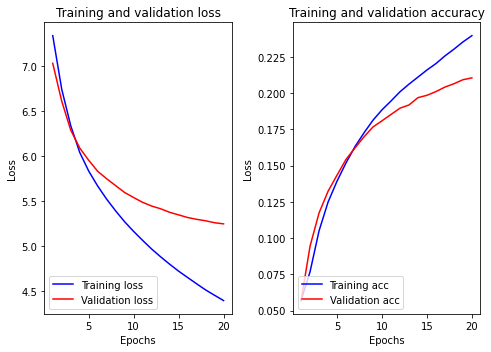

In [ ]:
# max sequence = 10
ResultsDisplay.plot_loss_and_accuracy_graphs(long_news_result_10seq['history'])

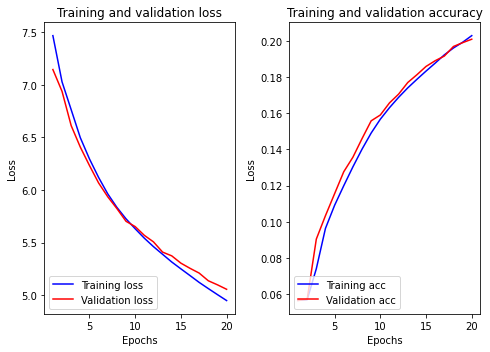

In [ ]:
# max sequence = 20
ResultsDisplay.plot_loss_and_accuracy_graphs(long_news_result_20seq['history'])

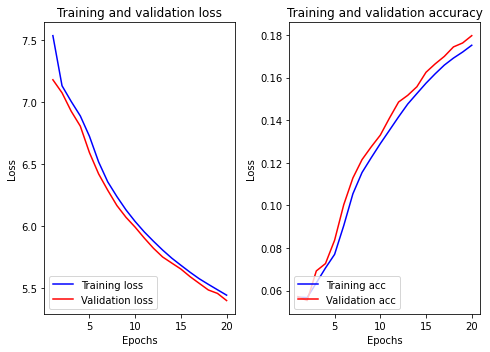

In [ ]:
# max sequence = 30 
ResultsDisplay.plot_loss_and_accuracy_graphs(long_news_result_30seq['history'])

## **Result:**
Using the same number of epoch, the model trains better with the long news dataset with max_seq_len=10 (although overfit, we will deal with that later) than the max_seq_size of 20 or 30. So we will proceed the rest of the experiments with long news dataset with max_seq_len=10. With shorter max_sequence, we have more training sets, that may explain the improved performance.

In [ ]:
# delete not needed data to free up memory
del long_news_result_20seq
del long_news_experiment_20seq
del long_news_dataset_20seq

del long_news_result_30seq
del long_news_experiment_30seq
del long_news_dataset_30seq

# **Experiment 3:** Comparing embeddings

We want to check what kind of embedding works better:


1.   Using no pretrained embedding (which was done in the previous experiment)
2.   Using GloVe 50 dimension pretrained embedding (set not retrainable)
3.   Using GloVe 50 dimension pretrained embedding (set retrainable)



In [ ]:
# We have already run the experiment, just capture the result here
result_3_1 = long_news_result_10seq

In [ ]:
experiment_50dim_not_trainable = Experiment(
                   "long news str 50-dim pretrained embedding (not trainable) ",
                   my_training_param,
                   EMBEDDING_DIM, 
                   long_news_dataset_10seq.embedding.embedding_matrix, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   False, # Set to False here as we don't want it to be trainable 
                   long_news_dataset_10seq)

EPOCH = 20
result_3_2  = experiment_50dim_not_trainable.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 527
dataset_val batch size: 131
Running long news str 50-dim pretrained embedding (not trainable) :Test first 20 epoch...

checkpoint_dir: ./training_checkpoints_12-01-04:00
(20002, 50)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pretrained-embedding (Embedd (128, None, 50)           1000100   
_________________________________________________________________
lstm_8 (LSTM)                (128, None, 256)          314368    
_________________________________________________________________
dropout_8 (Dropout)          (128, None, 256)          0         
_________________________________________________________________
dense_8 (Dense)              (128, None, 20000)        5140000   
Total params: 6,454,468
Trainable params: 5,454,368
Non-trainable params: 1,000,100
_________________________________________________________________
Epoch 1/20
527/527 [==

In [ ]:
experiment_50dim_trainable = Experiment(
                   "long news str 50-dim pretrained embedding (trainable) ",
                   my_training_param,
                   EMBEDDING_DIM, 
                   long_news_dataset_10seq.embedding.embedding_matrix, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   True, # use True here - we want it to be trainable 
                   long_news_dataset_10seq)

EPOCH = 20
result_3_3  = experiment_50dim_trainable.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 527
dataset_val batch size: 131
Running long news str 50-dim pretrained embedding (trainable) :Test first 20 epoch...

checkpoint_dir: ./training_checkpoints_12-01-04:11
(20002, 50)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pretrained-embedding (Embedd (128, None, 50)           1000100   
_________________________________________________________________
lstm_10 (LSTM)               (128, None, 256)          314368    
_________________________________________________________________
dropout_10 (Dropout)         (128, None, 256)          0         
_________________________________________________________________
dense_10 (Dense)             (128, None, 20000)        5140000   
Total params: 6,454,468
Trainable params: 6,454,468
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
527/527 [=============

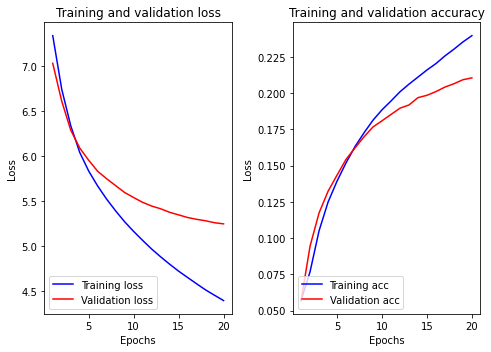

In [ ]:
# no pretrained embedding
ResultsDisplay.plot_loss_and_accuracy_graphs(result_3_1['history'])

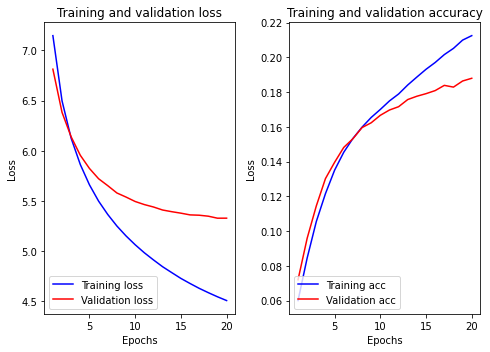

In [ ]:
# pretrained embedding, but not retrainable
ResultsDisplay.plot_loss_and_accuracy_graphs(result_3_2['history'])

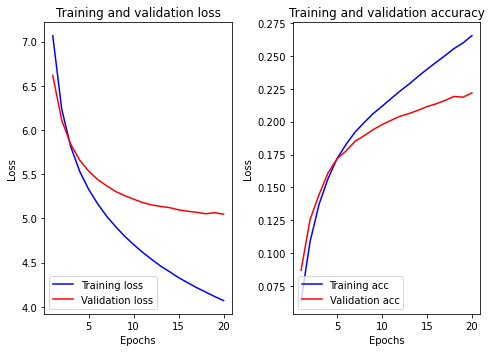

In [ ]:
# pretrained embedding and retrainable
ResultsDisplay.plot_loss_and_accuracy_graphs(result_3_3['history'])

## **Result:**

As we can see, option 3 (using a pretrained embedding, set to retrainable) performs the best. However, it also overfits. 

So we will continue other experiments with pretrained embedding matrix and set it to not retrainable (as suggested in the keras tutorial).


#**Experiment 4: Comparing Embedding Dimension**

We now want to test if the dimension of the pretrained embedding makes a difference. So we will try with 3 different options (all will be set to not retrainable):

1. 50 dim gloVe embedding (already done in Experiment #3 )

2. 200 dim gloVe embedding
3. 300 dim gloVe embedding

In [ ]:
# We have to construct 2 embedding matrix
pretrained200dim_embedding = PretrainedEmbedding(200, long_news_dataset_10seq.my_vocab)
pretrained300dim_embedding = PretrainedEmbedding(300, long_news_dataset_10seq.my_vocab)

# Make all embedding not trainable 
EMBEDDING_TRAINABLE = False

Found 400000 word vectors.
Converted 17577 words (2423 misses) in the embedding
Found 400000 word vectors.
Converted 17577 words (2423 misses) in the embedding


In [ ]:
# Option 1 is already done
result_4_1 = result_3_2

In [ ]:
experiment_200dim = Experiment(
                   "200-dim embedding",
                   my_training_param,
                   200, 
                   pretrained200dim_embedding.embedding_matrix, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   EMBEDDING_TRAINABLE, # if we pass in embedding_matrix, do we want it to be trainable 
                   long_news_dataset_10seq)

EPOCH = 20
result_4_2  = experiment_200dim.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 527
dataset_val batch size: 131
Running 200-dim embedding:Test first 20 epoch...

checkpoint_dir: ./training_checkpoints_12-01-04:24
(20002, 200)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pretrained-embedding (Embedd (128, None, 200)          4000400   
_________________________________________________________________
lstm_12 (LSTM)               (128, None, 256)          467968    
_________________________________________________________________
dropout_12 (Dropout)         (128, None, 256)          0         
_________________________________________________________________
dense_12 (Dense)             (128, None, 20000)        5140000   
Total params: 9,608,368
Trainable params: 5,607,968
Non-trainable params: 4,000,400
_________________________________________________________________
Epoch 1/20
527/527 [==============================] - 33s 63m

In [ ]:
experiment_300dim = Experiment(
                   "300-dim embedding",
                   my_training_param,
                   300, 
                   pretrained300dim_embedding.embedding_matrix, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   EMBEDDING_TRAINABLE, # if we pass in embedding_matrix, do we want it to be trainable 
                   long_news_dataset_10seq)

EPOCH = 20
result_4_3  = experiment_300dim.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 527
dataset_val batch size: 131
Running 300-dim embedding:Test first 20 epoch...

checkpoint_dir: ./training_checkpoints_12-01-04:36
(20002, 300)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pretrained-embedding (Embedd (128, None, 300)          6000600   
_________________________________________________________________
lstm_14 (LSTM)               (128, None, 256)          570368    
_________________________________________________________________
dropout_14 (Dropout)         (128, None, 256)          0         
_________________________________________________________________
dense_14 (Dense)             (128, None, 20000)        5140000   
Total params: 11,710,968
Trainable params: 5,710,368
Non-trainable params: 6,000,600
_________________________________________________________________
Epoch 1/20
527/527 [==============================] - 33s 63

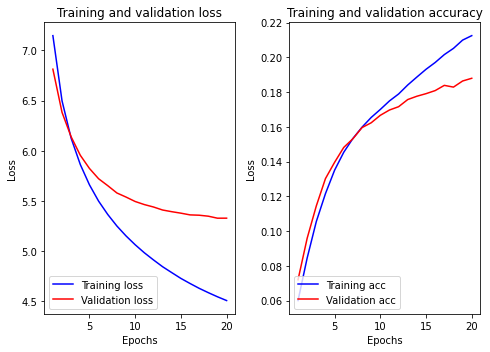

In [ ]:
# 50 dim 
ResultsDisplay.plot_loss_and_accuracy_graphs(result_4_1['history'])

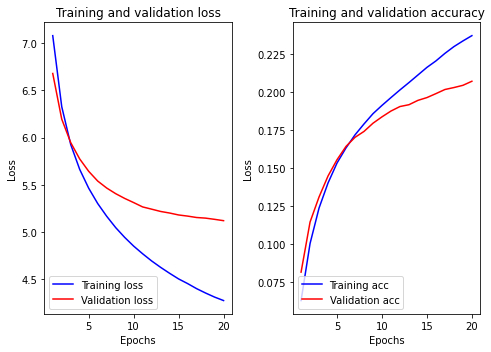

In [ ]:
# 200 dim 
ResultsDisplay.plot_loss_and_accuracy_graphs(result_4_2['history'])

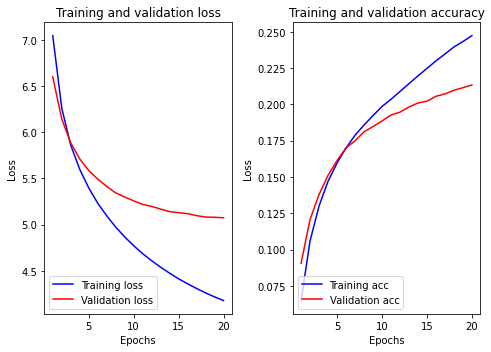

In [ ]:
# 300 dim 
ResultsDisplay.plot_loss_and_accuracy_graphs(result_4_3['history'])

## **Result:** 

300 dimension embedding matrix performs better (although the difference between 200dim and 300dim is not that much). 

However we will continue further experiments with a pretrained embedding of **50dim** only (for faster training and lower memory usage) with retrainable setting. In the final model, we may use the higher dimension embedding.

# **Experiment 5: Comparing num of LSTM layers**
Using diff number of LSTM layers:

Options:
1. Using 1 LSTM layer (already did in experiment 3.3 & 4.1)
2. Using 2 LSTM layer 

In [ ]:
result_5_1 = result_4_1

In [36]:
RNN_UNITS = 256
DROPOUT = 0.1
LSTM_LAYER = 2
my_training_param = {'rnn_units' : RNN_UNITS,
                     'dropout'   : DROPOUT,
                     'lstm_layer': LSTM_LAYER}

experiment_50dim_lstm2 = Experiment(
                   f"50-dim  {LSTM_LAYER} LSTM layer",
                   my_training_param,
                   EMBEDDING_DIM, 
                   long_news_dataset_10seq.embedding.embedding_matrix, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   False, # if we pass in embedding_matrix, do we want it to be trainable 
                   long_news_dataset_10seq)

EPOCH = 30
result_5_2  = experiment_50dim_lstm2.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 527
dataset_val batch size: 131
Running 50-dim  2 LSTM layer:Test first 30 epoch...

checkpoint_dir: ./training_checkpoints_12-01-15:14
(20002, 50)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pretrained-embedding (Embedd (128, None, 50)           1000100   
_________________________________________________________________
lstm_18 (LSTM)               (128, None, 256)          314368    
_________________________________________________________________
dropout_18 (Dropout)         (128, None, 256)          0         
_________________________________________________________________
lstm_19 (LSTM)               (128, None, 256)          525312    
_________________________________________________________________
dropout_19 (Dropout)         (128, None, 256)          0         
_________________________________________________________________
dense_14 (D

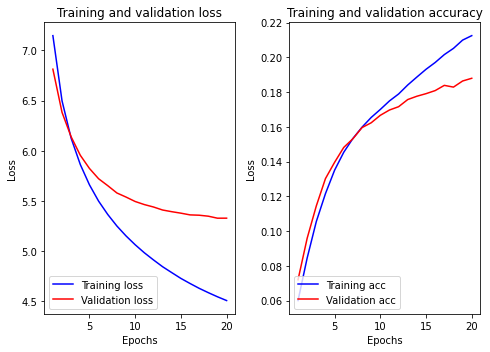

In [ ]:
# 1 LSTM layer 
ResultsDisplay.plot_loss_and_accuracy_graphs(result_5_1['history'])

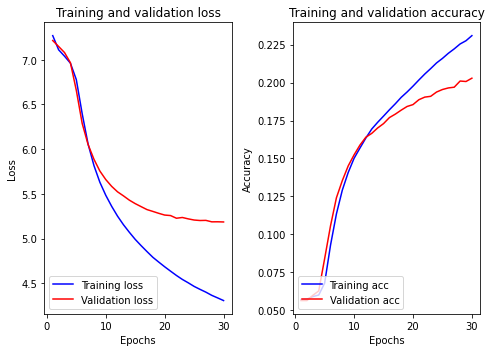

In [90]:
# 2 LSTM layer 
ResultsDisplay.plot_loss_and_accuracy_graphs(result_5_2['history'])

## **Result:**

Using additional LSTM layer did not improve the performance by much, but it does reduce the variance (in additional to each LSTM layer, it also add the same number of DROPOUT layer).  We will use 2 LSTM in the final model.

# **Experiment 6: Comparing num RNN units**

Choosing RNN_UNITS (all trained with the same numbers of LSTM + DROPOUT layer)

Options:
1. Using 256 units (already did in experiment 5.2)
2. Using 1024 units


In [40]:
result_6_1 = result_5_2

In [43]:
RNN_UNITS = 1024
DROPOUT = 0.1
LSTM_LAYER = 2
my_training_param = {'rnn_units' : RNN_UNITS,
                     'dropout'   : DROPOUT,
                     'lstm_layer': LSTM_LAYER}

experiment_50dim_rnn1024 = Experiment(
                   f"50-dim  {LSTM_LAYER} LSTM layer (RNN={RNN_UNITS})",
                   my_training_param,
                   EMBEDDING_DIM, 
                   long_news_dataset_10seq.embedding.embedding_matrix, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   EMBEDDING_TRAINABLE, # if we pass in embedding_matrix, do we want it to be trainable 
                   long_news_dataset_10seq)

EPOCH = 30
result_6_3  = experiment_50dim_rnn1024.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in the model 
                          EPOCH ) 

dataset_train batch size: 527
dataset_val batch size: 131
Running 50-dim  2 LSTM layer (RNN=1024):Test first 30 epoch...

checkpoint_dir: ./training_checkpoints_12-01-15:28
(20002, 50)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pretrained-embedding (Embedd (128, None, 50)           1000100   
_________________________________________________________________
lstm_26 (LSTM)               (128, None, 1024)         4403200   
_________________________________________________________________
dropout_26 (Dropout)         (128, None, 1024)         0         
_________________________________________________________________
lstm_27 (LSTM)               (128, None, 1024)         8392704   
_________________________________________________________________
dropout_27 (Dropout)         (128, None, 1024)         0         
_________________________________________________________________


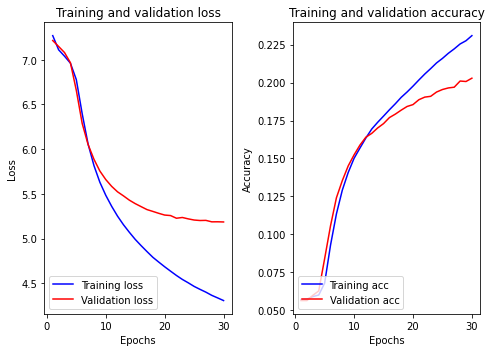

In [92]:
# 2 LSTM layer with rnn=256
ResultsDisplay.plot_loss_and_accuracy_graphs(result_6_1['history'])

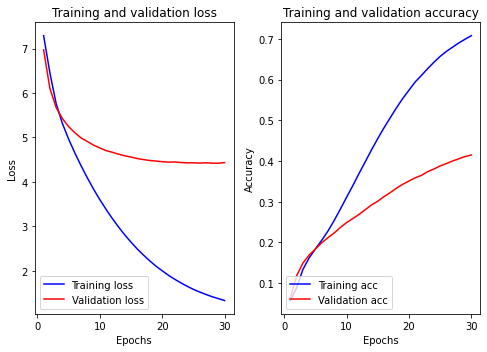

In [93]:
# 2 LSTM layer with rnn=1024
ResultsDisplay.plot_loss_and_accuracy_graphs(result_6_3['history'])

## **Result:**

Increasing RNN units improves more than increasing the LSTM layers. Using more RNN units does improve the model performance (although we still have overfitting). We will use more RNN units in the final model.



In [95]:
start_string_list = ['Today is a good',
                   'Trump is',
                   'US plans to',
                   'Small business suffers',
                   'Tomorrow we will know',
                   'there were 2 mass shootings in texas last week',
                   'US stock market will continue to',
                   'The Oscar goes to',
                   "What is",
                   "Gunmen Assassinate Iran’s Top Nuclear Scientist",
                   "Iran’s president blames Israel for killing nuclear scientist and vows to",
                   "Man linked the killing of",
                   "This Thanksgiving"
                   ]
result_tester = ResultsDisplay(start_string_list) 

Experiment: 50-dim  2 LSTM layer (RNN=1024):Test first 30 epoch
training_param: {'rnn_units': 1024, 'dropout': 0.1, 'lstm_layer': 2}
max_seq_len: 10




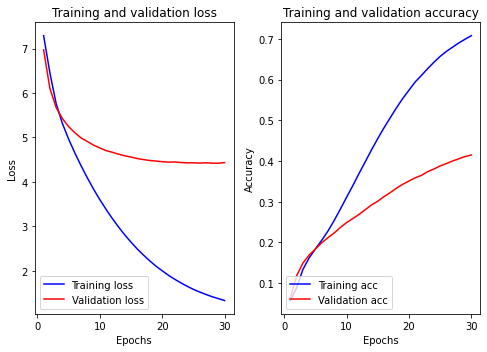

#1:  Today is a good...
         mechanism and challenging the wall street financier linton pushed by refusing deportees at chairman of a republican lawmaker ron johnson
#2:  Trump is...
         expected to arrive to pakistan to be honest trustworthy twoincome ad buys insurance markets have that they support from seven
#3:  US plans to...
         invade north korea according to advise the democratic presidential opponent for business chief executive order that washington on nbcs ceremony
#4:  Small business suffers...
         in which depend its political was sending from quoting only partially granted when asked how he was going and training
#5:  Tomorrow we will know...
         very fast halt congress might the insurance plans on thursday by former democratic lawmakers have concluded to deliver deep the
#6:  there were 2 mass shootings in texas last week...
         sought to help farmers automakers in last november he expected for the testimony said on china since 1994 with him


In [96]:
# Showing text generation of the last best performed model in the experiements
result_tester.show_experiment_results(result_6_3, long_news_dataset_10seq.my_vocab)


# **Experimentation Summary:** 

After running all different experiments, we concluded that the final model should use the long news dataset. The long news dataset performs better (expected) because there are more related text sequence within the same news, rather than shorter descriptions of different unrelated news joined together.  The training input and target pairs may be meaningless when the different news joined in the text file and made up a sequece. Short news has higher probability of such unrelated words in the same sequences. 

Using a smaller max_sequence_length also helps breaking the datasets into more sequences (hence more training samples). That improves training.  

Using a pretrained embedding of high dimension (e.g., 300) also helps improve the performance.   

Using additional LSTM layer does not improve the performance, although with more LSTM (and the DROPOUT layers), it helps reduce overfitting a little.
Using more RNN units per LSTM layer definitely improves the performance. 

So we will use higher RNN units in the final model.


## **Train the final model**


Now train our final model using a larger batch size and with 1024 RNN units, using 300 dim pretrained embedding. 

In [52]:
VALIDATION_SPLIT = 0.2 
BATCH_SIZE = 128
EMBEDDING_DIM = 300  # increase the dimension 
MAX_TOKENS = 20000 # this is fixed to 20K for all tests 
TEXT_LIMIT = 5800000 

long_news_file_path = DATA_DIR+'true_news_text.txt'
my_dataset = TextDataset(long_news_file_path, TEXT_LIMIT, MAX_TOKENS, EMBEDDING_DIM, 10, VALIDATION_SPLIT, BATCH_SIZE)

Found 400000 word vectors.
Converted 17577 words (2423 misses) in the embedding

dataset size: 84478
num_validation_samples: 16895
dataset_train size: 67583
dataset_val size: 16895
dataset_train batch size: 527
dataset_val batch size: 131


In [102]:
RNN_UNITS = 1024
DROPOUT = 0.4 # use higher drop out if needed more regularization 
LSTM_LAYER = 2

my_training_param = {'rnn_units' : RNN_UNITS,
                     'dropout'   : DROPOUT,
                     'lstm_layer': LSTM_LAYER}

final_model = Experiment(
                   f"{LSTM_LAYER}LSTM dropout={DROPOUT}",
                   my_training_param,
                   EMBEDDING_DIM, 
                   my_dataset.embedding.embedding_matrix, # if we don't pass in any, will use the untrained embedding (that is fully trainable)
                   False, # Not retrainable 
                   my_dataset)

EPOCH = 100
result1  = final_model.run_experiment(
                          f"Test first {EPOCH} epoch",
                          None,  # if we want to continue training from previous run, pass in previous result dictionary 
                          EPOCH ) 

dataset_train batch size: 527
dataset_val batch size: 131
Running 2LSTM dropout=0.4:Test first 100 epoch...

checkpoint_dir: ./training_checkpoints_12-01-17:51
(20002, 300)
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pretrained-embedding (Embedd (128, None, 300)          6000600   
_________________________________________________________________
lstm_58 (LSTM)               (128, None, 1024)         5427200   
_________________________________________________________________
dropout_58 (Dropout)         (128, None, 1024)         0         
_________________________________________________________________
lstm_59 (LSTM)               (128, None, 1024)         8392704   
_________________________________________________________________
dropout_59 (Dropout)         (128, None, 1024)         0         
_________________________________________________________________
dense_34 (De

Experiment: 2LSTM dropout=0.4:Test first 100 epoch
training_param: {'rnn_units': 1024, 'dropout': 0.4, 'lstm_layer': 2}
max_seq_len: 10




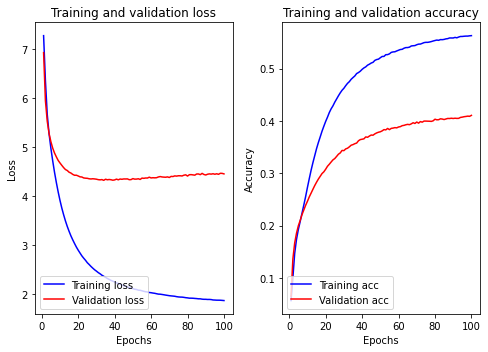

#1:  Today is a good...
         deal us technology with its new hampshires secretary jim mattis on wednesday clearing a relaxation new emergency management prevezons oversight
#2:  Trump is...
         expected with homeland security issues such a lucrative business income tax legislation that he stirred around the president donald trump
#3:  US plans to...
         block grants only the stunt that the younger older offpatent 63 percent of the senate if they could not a
#4:  Small business suffers...
         that was forced to a warrant before the notorious attacks and whitefishs deal and others it offering than half 800000
#5:  Tomorrow we will know...
         what at the resolution to deal and militias against him there has currently in 2013 said the senators on a
#6:  there were 2 mass shootings in texas last week...
         asked the weapons and it for several congressional aides say it us territories on us senate confirms charges that exist
#7:  US stock market will continue t

In [105]:
# Show the text generation with what we got so far
result_tester.show_experiment_results(result1, my_dataset.my_vocab)

In [107]:
# Try generating different text
result_tester.test_generate_text(start_string_list, result1['predict'], my_dataset.my_vocab, 10)

#1:  Today is a good...
         deal were not immediately respond to block an industry officials
#2:  Trump is...
         expected in the federal law requires 60 percent of supreme
#3:  US plans to...
         cut the last week although adding for tax rate for
#4:  Small business suffers...
         that owns directv on its bills a housesenate senate that
#5:  Tomorrow we will know...
         what were receiving support conservative republicans and tweeted and white
#6:  there were 2 mass shootings in texas last week...
         abbott on wednesday to repeated meeting with a dinner room
#7:  US stock market will continue to...
         be hardpressed and republican effort to express condolences satisfaction in
#8:  The Oscar goes to...
         wall the company att incs program that would destroy the
#9:  What is...
         for engaging as the world for childhood arrivals daca mansion
#10:  Gunmen Assassinate Iran’s Top Nuclear Scientist...
         in us president on solid differe

As we can see, the generated text is somewhat coherent, althought not making complete sense.  It is not completely random. 

# **Conclusion:**

The model we have tends to have larger variance over time. Increasing the dropout does reduce the overfitting but cannot prevent it. The validation accuracy will eventually improve at a slower rate than the training accuracy (which will keep improving with additional training).

Our final model (with text size limit) can achieve the training accuracy of > 0.5 and validation accuracy of > 0.4 in the first 100 Epoch. This is good consider the relatively short time we use for training. 

The classes created for this project can help us easily set up new datasets based on a given text file and we can use it do train different text generation models (will have the style of the dataset text).

Lessons learned:

* Using a big dataset is good, but the relationships of segments/sentences within the text always matter. I decided to go with "merged" text because when I trained earlier with different news being kept as different samples, we either have to truncate a lot of sentences and lost valuable training data, or pad the shorter sentences. When we have a lot of padding, the model tend to predict 0 index very often because there is a lot of padding in the training target.

* Having pretrained embedding does help improving the accuracy because we are using generate text that follows a language model. If we want to use this to generate other kinds of predictions (like customer orders), we should pretrain the embedding of the input object, so that we can understand the relationships between different objects.


